# Constructing the Neural Network

Goal: Predict ranking of a hypothetical song given the artists that are featured on it.

Training data: all songs UP TO a given date.
Testing data: All songs on that date

If an artist has no previous information, give a small default past performance.
As a reminder, here are the columns:
```
decades_since_2020_Sept,date,rank, rank_norm,title,main_artist,featured_artists, artist_past_performance, features_past_performance
```

Relevant columns: artist_past_performance and features_past_performance basically. Other columns are useful as well, but these are 'main'

Any need for embedding before proceeding?

Training for 2025-07-26


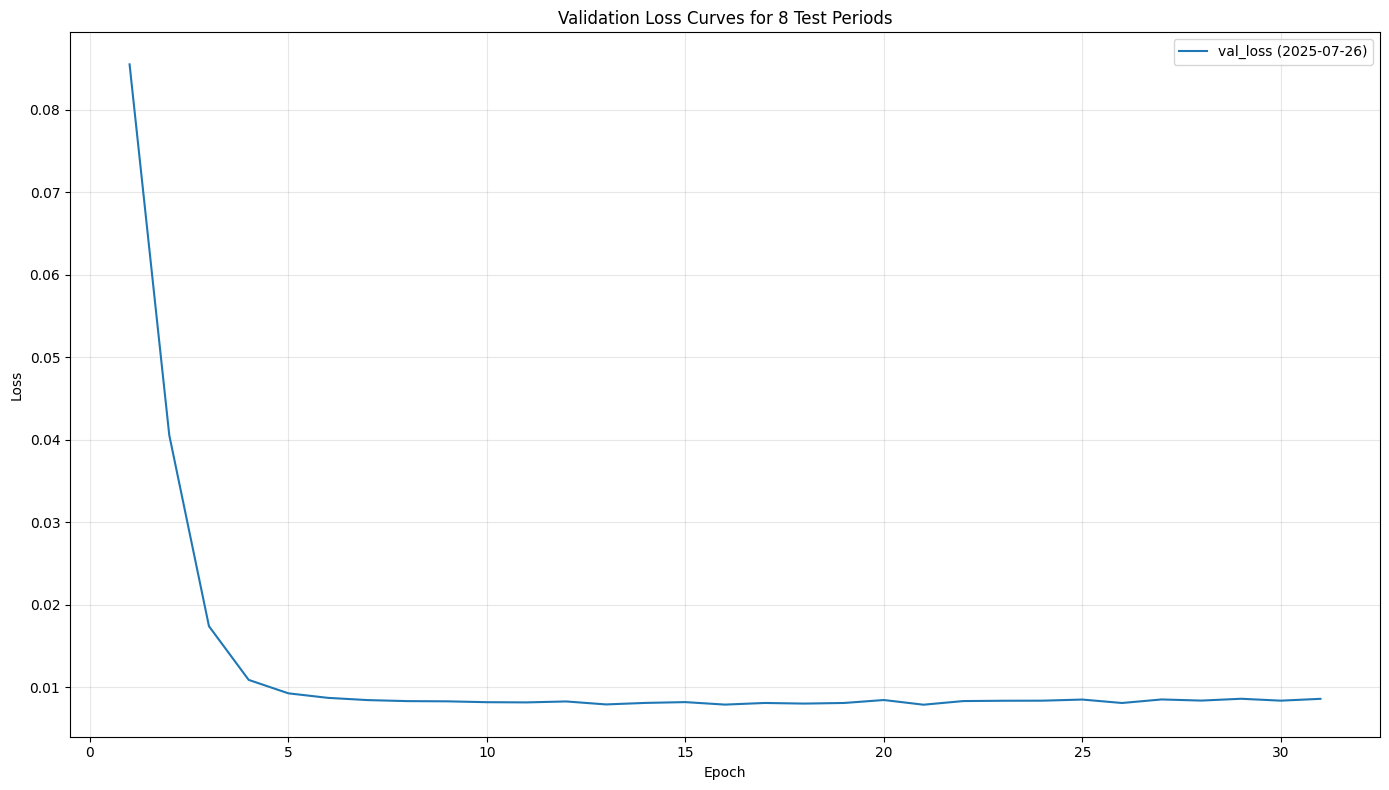

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Training configuration
EPOCHS_MAIN = 100
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.05
PATIENCE = 10

# Load engineered data
df = pd.read_csv("data/clean3.csv", dtype=str)
# Fix headers that may contain leading/trailing spaces
df.columns = df.columns.str.strip()

# Parse types
df["decades_since_2020_Sept"] = df["decades_since_2020_Sept"].astype(float)
df["rank"] = df["rank"].astype(int)
df["rank_norm"] = df["rank_norm"].astype(float)
df["artist_past_performance"] = df["artist_past_performance"].astype(float)
df["features_past_performance"] = df["features_past_performance"].astype(float)
df["date"] = pd.to_datetime(df["date"])

# Feature extras
def count_features(s: str) -> int:
    s = (s or "").strip()
    if s == '"None"' or s == "" or s.lower() == 'none':
        return 0
    # count names inside single quotes
    return len([m for m in s.split("'") if m.strip() and m.strip() != "," ]) // 2

df["num_features"] = df["featured_artists"].apply(count_features).astype(int)
df["has_features"] = (df["num_features"] > 0).astype(int)
df["main_x_feats"] = df["artist_past_performance"] * df["features_past_performance"]

feature_cols = [
    "artist_past_performance",
    "features_past_performance",
    "decades_since_2020_Sept",
    "num_features",
    "has_features",
    "main_x_feats",
]
target_col = "rank_norm"

# Requested test dates (now 8 periods)
test_dates = [
    pd.Timestamp("2025-07-26"),
]

# test_dates = [
#     pd.Timestamp("2021-03-06"),
#     pd.Timestamp("2022-02-05"),
#     pd.Timestamp("2023-02-25"),
#     pd.Timestamp("2023-10-07"),
#     pd.Timestamp("2024-05-11"),
#     pd.Timestamp("2024-12-21"),
#     pd.Timestamp("2025-07-19"),
#     pd.Timestamp("2025-07-26"),
# ]


results = []
plt.figure(figsize=(14, 8))

for i, test_date in enumerate(test_dates):
    print(f"Training for {test_date.date()}")
    train_df = df[df["date"] < test_date].copy()
    test_df  = df[df["date"] == test_date].copy()
    # If train or test is empty, try to include at least one row for test
    if len(train_df) == 0:
        print(f"Warning: No training data before {test_date.date()}, skipping.")
        continue
    if len(test_df) == 0:
        # Try to find closest available date
        available = df[df["date"] > test_date]["date"]
        if not available.empty:
            closest = available.min()
            print(f"Warning: No test data for {test_date.date()}, using closest available date {closest.date()}.")
            test_df = df[df["date"] == closest].copy()
        else:
            print(f"Warning: No test data for {test_date.date()} and no later dates, skipping.")
            continue

    X_train = train_df[feature_cols].astype(float).values
    y_train = train_df[target_col].astype(float).values
    X_test = test_df[feature_cols].astype(float).values
    y_test = test_df[target_col].astype(float).values

    def build_model(input_dim: int) -> keras.Model:
        inputs = keras.Input(shape=(input_dim,))
        x = keras.layers.Dense(32, activation="relu")(inputs)
        x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Dense(16, activation="relu")(x)
        outputs = keras.layers.Dense(1, activation="sigmoid")(x)
        model = keras.Model(inputs, outputs)
        model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
        return model

    model = build_model(len(feature_cols))
    es = keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True, monitor="val_loss")
    hist = model.fit(
        X_train, y_train,
        epochs=EPOCHS_MAIN,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        callbacks=[es],
        verbose=0
    )

    # Evaluate
    pred = model.predict(X_test, verbose=0).reshape(-1)
    def norm_to_rank(y):
        y = np.clip(y, 1e-6, 1.0)
        return np.minimum(200, np.round((1.0 / (y**2))).astype(int))

    test_rank_true = test_df["rank"].values
    test_rank_pred = norm_to_rank(pred)

    mae_norm = np.mean(np.abs(pred - y_test))
    mae_rank = np.mean(np.abs(test_rank_pred - test_rank_true))

    results.append({
        "date": test_date,
        "mae_norm": mae_norm,
        "mae_rank": mae_rank,
        "hist": hist.history,
    })

    # Plot training/validation loss curve for this period
    hist_df = pd.DataFrame(hist.history)
    hist_df["epoch"] = np.arange(1, len(hist_df) + 1)
    label = f"val_loss ({str(test_date.date())})"
    plt.plot(hist_df["epoch"], hist_df["val_loss"], label=label)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Curves for 8 Test Periods")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model('models/billboard_predictions/model_2025-07-26.keras')

input_data = [np.array([[0.17905095514363856, 0.15044507426278467, 0.4906910328587075, 2, 1, 0.01]])]

prediction = model.predict(input_data)

rank = min(200, round(1.0 / (prediction[0, 0] ** 2)))

print("Predicted normalized rank:", prediction[0, 0])
print("Predicted rank:", rank)